## Unresolved Problems
- background replaced by backilogramround when 'kg' replaced with 'kilogram

In [10]:
!pip install -r ../semantic_search/requirements.txt


  Using cached mysoc_dataset-0.3.0-py3-none-any.whl (9.3 kB)
  Using cached pytextrank-3.2.4-py3-none-any.whl (30 kB)
  Using cached textblob-0.17.1-py2.py3-none-any.whl (636 kB)
  Using cached keybert-0.7.0-py3-none-any.whl
  Using cached keyphrase_vectorizers-0.0.11-py3-none-any.whl (29 kB)
  Using cached umap_learn-0.5.3-py3-none-any.whl
  Using cached bertopic-0.14.1-py2.py3-none-any.whl (120 kB)
  Using cached rich_click-1.6.1-py3-none-any.whl (19 kB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached icecream-2.1.3-py2.py3-none-any.whl (8.4 kB)
  Using cached spacy_transformers-1.2.2-cp39-cp39-win_amd64.whl (302 kB)
  Using cached executing-1.2.0-py2.py3-none-any.whl (24 kB)
  Using cached asttokens-2.2.1-py2.py3-none-any.whl (26 kB)

In [3]:
import sys

sys.path.append("../semantic_search")

from utils import clean3, is_pua, remove_punct_nums

In [4]:
from sentence_transformers import SentenceTranformer

KeyboardInterrupt: 

In [5]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
# import spacy
import re

# from sentence_transformers import SentenceTransformer, util #this line causing trouble atm
import pickle
from tqdm.notebook import tqdm
import torch
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
%matplotlib inline

## Pulling data

In [10]:
import os
print(os.getcwd())

c:\Users\Louis\Louis coding files\my_society\notebooks


In [11]:
#reading and cleaning
df = pd.read_excel(r"..\data\raw\plans.xlsx")
drop_cols = ['search_link','type','charset','unfound','credit','date_retrieved','time_period','scope','status',
            'well_presented', 'baseline_analysis', 'notes', 'plan_path','file_type','website_url',
            'authority_code', 'authority_type', 'wdtk_id',
           'mapit_area_code', 'country', 'gss_code', 'county', 'region',
           'population', 'unfound','credit','homepage_mention', 'dedicated_page',
            'plan_due','title','title_checked','twitter_url','twitter_name','url']
df = df.drop(drop_cols,axis=1)
df = df[df['text'].notna()]
df['text'] = df['text'].apply(clean3)
df = df.drop([125, 494],inplace=False) #removing faulty-text ones



KeyboardInterrupt: 

In [2]:
df[df['text']=='']

NameError: name 'df' is not defined

In [8]:
print(list(df.loc[[125, 494]]['text']))

['', '']


In [46]:
print(df.loc[[145]]['text'].values)

['report no ppeden district council executive november zero carbon eden strategy portfolio sustainability report from assistant director delivery wards all open public item purpose this report is to seek isation to approve the new strategy regarding to the implementation of the action plan to make the council s operations zero carbon by recommendation it is recommended that the strategy and action plan set out in be approved.report details in order to respond to climate issues that have been caused by an increase in anthropogenic greenhouse gas emissions, eden district council is taking action to reduce our emissions and to find solutions to mitigate the effects of climate change.eden district council declared a climate and ecological emergency in july the objective is to make the council s operations zero carbon by to encourage initiatives which help eden district to become net zero carbon.to improve biodiversity while preserving our working cultural landscapes and economies.our wish 

In [47]:
df.to_csv('../data/processed/week5_clean_plans.csv')

In [48]:
df = pd.read_csv('../data/processed/week5_clean_plans.csv')

In [49]:
df.loc[145]

Unnamed: 0.1                                                  145
Unnamed: 0                                                    187
council                                     Eden District Council
text            report no ppeden district council executive no...
Name: 145, dtype: object

In [50]:
corpus = df['text'].to_list()

In [51]:
len(corpus)

500

In [52]:
test = corpus[144]
test

'a climate and environmental emergency action plan update june programme action impact target progress ecology ecology carbon sequestration schemes localised carbon proposals for a small number of proposals being work in partnership to develop proposals offsetting, habitat schemes by end of considered, linkages being made with for large scale habitat creation projects and creation and reducing carbon offsetting, tree programme, secure funding to deliver schemes that can localised nutrient housing and the biodiversity plan sequester carbon.budgeting issues.development actions ecology ecology monitoring ecological mitigation to assess the impact a review of capacity the review identified a need for greater actions.review funding made available of adopted mitigation was completed by ecology resources and the team has been through planning conditions, including measures on march expanded from one officer to four.the ensuring that it can allow the commissioning biodiversity through team are

## Truncation 
- model='all-MiniLM-L6-v2' is default in keyBERT. This automatically truncates each doc to 128 words
- can increase this to max of 512 tokens but this will not cover entire documents so need to do this manually.
- atm doing this in cleaning-test.ipynb 

## Tokenizer and Model

In [7]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

print("Max Sequence Length:", model.max_seq_length)

model.max_seq_length = 512

print("Max Sequence Length:", model.max_seq_length)

NameError: name '_C' is not defined

## Manual truncation
- Is there a problem with longer plans counting for multiple documents
- 500 plans goes to ~3000 documents so worst case they are 6 times as important

In [111]:
from sklearn.feature_extraction.text import CountVectorizer


def truncate_plan(plan, n):
    tokenizer = CountVectorizer().build_tokenizer()
    #note that now plans will not have full stops
    tokens = tokenizer(plan)
    return [' '.join(tokens[i:i+n]) for i in range(0, len(tokens), n)]

truncated_corpus = {}
for i,v in enumerate(corpus):
    truncated_corpus[i] = truncate_plan(v,512)
#     truncated_corpus.extend(truncate_plan(i,512))

In [53]:
def split_text(text: str, max_tokens: int = 512):
    sentences = text.split('.')
    chunks = []
    current_chunk = ''
    current_token_count = 0
    for sentence in sentences:
        tokens = sentence.split()
        if current_token_count + len(tokens) <= max_tokens:
            current_chunk += sentence + '.'
            current_token_count += len(tokens)
        else:
            chunks.append(current_chunk)
            current_chunk = sentence + '.'
            current_token_count = len(tokens)
    if current_chunk:
        chunks.append(current_chunk)
    return chunks

split_dict = {}
for i,v in enumerate(corpus):
    split_dict[i] = split_text(v)


In [54]:
x = [[key]*len(split_dict[key]) for key in split_dict.keys()]
plan_index = [item for sublist in x for item in sublist]

In [56]:
len(plan_index)

3073

In [22]:
len([item for sublist in split_dict.values() for item in sublist if not (isinstance(x, float) and math.isnan(x))])

3073

In [220]:
mb = pd.DataFrame.from_dict(split_dict, orient='index')
mb.to_csv('../data/processed/split_corpus.csv')

In [222]:
mb

,0,1,2,3,4,5,6,7,8,9
0,aberdeen city council energy and climate plan ...,our role our overall role is two fold to gover...,"after which, implementation will see significa...",the first two thematic groups are enabling gro...,develop and deliver different formats and dept...,a scheme of smarter working is already in plac...,"absorbing carbon dioxide, contributing to clim...",None,None,None
1,aberdeen adapts aberdeen s climate adaptation ...,"by learning from these measures, aberdeen is w...",aberdeen adapts climate adaptation framework t...,aberdeen adapts climate adaptation framework w...,the market for goods and services in this sect...,although investment is being made in city floo...,"from an international airport, to a busy city ...",climate change is also a threat to aberdeen s ...,aberdeen adapts climate adaptation framework a...,None
2,council climate change plan towards a net zero...,how will we meet our target project summary on...,re shape our operational activity but also whe...,our council condition and suitability programm...,aberdeen city council i council climate change...,change act with a scottish government target t...,None,None,None,None
3,a climate positive city at the heart of the gl...,"of net zero carbon emissions and beyond, whils...",fact that we have a unique position in the glo...,being home to a family of internationally thos...,a climate positive city at the heart of the gl...,the decarbonisation of energy generation neith...,local areas are best placed to drive emission ...,"million activity, science centre, research hub...",None,None
4,carbon neutral plan working towards the target...,this work is intended to provide the councils ...,non residential external crematorium transpor...,demand reduction measures have less impact whe...,prepared for adur and worthing councils adur a...,building integrated renewable energy generatio...,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
495,wychavon intelligently green plan welcome .sum...,by by and how we will lead the district to cut...,we will use the following success measures to ...,"hundreds climate crisis at global, national an...",the midlands energy hub is commissioning a stu...,"the clean growth strategy, published in octobe...",in july the climate change committee published...,None,None,None
496,climate change action plan council operations ...,review land continue to review council owned o...,None,None,None,None,None,None,None,None
497,climate change action plan wider borough our g...,tree planting follow our commitment to plant a...,None,None,None,None,None,None,None,None
498,restore revive thrive our environment climate ...,as climate change represents a significant thr...,"and we must ensure that the council, and its a...",develop key actions monitor progress and repor...,ensuring that vulnerable groups who are embedd...,this is equivalent to of the council s scope a...,None,None,None,None


In [223]:
# dft = pd.DataFrame([(k, v) for k, lst in truncated_corpus.items() for v in lst], columns=['key', 'text'])
# dft

In [26]:
dft.to_csv('../data/processed/truncated_corpus_keep_plan_number.csv')

In [11]:
trunk_df = pd.DataFrame(truncated_corpus)
trunk_df.to_csv('../data/processed/week5_truncated_corpus.csv')

## Load in truncated corpus

In [229]:
#choice on whether to load in plans where plan-number is kept or not
trunk_df = pd.read_csv('../data/processed/week5_truncated_corpus.csv')
truncated_corpus = trunk_df['0'].to_list()

split_df = pd.read_csv('../data/processed/split_corpus.csv')
split_df = split_df.drop(['Unnamed: 0'],axis=1)
split_corpus = split_df.values().flatten().tolist()

In [246]:
import math
split_corpus = [x for x in split_corpus if not (isinstance(x, float) and math.isnan(x))]

In [247]:
len(split_corpus)

3073

## Define the vecotoriser
- lemmatize documents
- remove stopwords
- choose ngram range

In [18]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer       
from nltk.stem import WordNetLemmatizer 

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [19]:
#let's define a unigram-tokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
nltk.download('averaged_perceptron_tagger')
class unigramTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.pos = pos_tag
    def __call__(self, articles):
        tokenized = word_tokenize(articles)
        return [self.wnl.lemmatize(word) for (word, pos) in nltk.pos_tag(tokenized) if(pos[:2] == 'NN')]


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/faculty/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [162]:
# a = unigramTokenizer()
# a(truncated_corpus[0])

In [248]:
#extract vocab using count vectoriser.
#min_df = 0.004 gives vocab of 10000 words
#0.001 gives 56000
#mindf=1 gives 360 000
#mindf=2 gives 106 000
# count = CountVectorizer(stop_words='english',min_df=0.1,ngram_range=(2,2),tokenizer= unigramTokenizer())
# vocab = count.fit(truncated_corpus).get_feature_names_out()

from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer

kw_model = KeyBERT(model)
my_vectorizer = KeyphraseCountVectorizer(pos_pattern= '<J.*>?<N.*>{1,2}')#pos_pattern='<N.*>')
vocab  = my_vectorizer.fit(split_corpus).get_feature_names_out()


In [249]:
len(list(vocab))

92689

## Embed documents
- how should these be stored when model deployed
- for now just store them as local variable
- use the current best practice for storing the model

In [250]:
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer

kw_model = KeyBERT(model)

#parameters that must be the same
#this vectoriser gives vocab of ~8000 words
# my_vectoriser = CountVectorizer(
#     stop_words='english',
#     min_df=0.05,
#     ngram_range=(1,1),
#     tokenizer= LemmaTokenizer()
# )
#vectoriser to find noun keyphrases. don't want keyphrases of more than 3 
my_vectorizer = KeyphraseCountVectorizer(pos_pattern= '<J.*>?<N.*>{1,2}')#pos_pattern='<N.*>')

doc_embeddings, word_embeddings = kw_model.extract_embeddings(split_corpus,
                                                              vectorizer = my_vectorizer
                                                             )


In [252]:
#parameters that can be tuned
diversity = 0.6
top_n=10

keywords = kw_model.extract_keywords(split_corpus,
                                   #  use_maxsum=True,
                                   #  nr_candidates= nr_candidates,
                                     use_mmr=True,
                                     diversity = diversity,
                                     top_n= top_n,
                                     vectorizer = my_vectorizer,
                                     doc_embeddings=doc_embeddings, 
                                     word_embeddings=word_embeddings
                                    )



In [253]:
keywords

[[('climate action', 0.4775),
  ('new council energy', 0.4213),
  ('sustainable development goals', 0.3887),
  ('national adaptation programme', 0.3476),
  ('improvement plan', 0.2898),
  ('aberdeen city', 0.2437),
  ('routemap supports', 0.1999),
  ('resilient', 0.1856),
  ('legal framework', 0.1815),
  ('seismic shift', 0.0527)],
 [('strategy council', 0.4443),
  ('local development plan', 0.4357),
  ('energy climate', 0.378),
  ('local transport', 0.2687),
  ('aberdeen adapts', 0.2484),
  ('phases', 0.2276),
  ('property asset', 0.2229),
  ('include', 0.2003),
  ('setting process', 0.174),
  ('define', 0.1075)],
 [('statutory climate change', 0.4843),
  ('scottish government', 0.4324),
  ('thematic groups', 0.3364),
  ('property refurbishment', 0.2478),
  ('hydrogen projects', 0.2387),
  ('financial options', 0.2332),
  ('external support', 0.228),
  ('phase measure', 0.1367),
  ('active travel', 0.1347),
  ('review', 0.0981)],
 [('sustainable procurement', 0.4701),
  ('climate comm

In [20]:
vocab = my_vectorizer.fit(split_corpus).get_feature_names_out()

In [523]:
vocab

dict_keys(['medium medium qtr', 'source council', 'decisions.development goals', 'transport council', 'environmental corporation', 'private housing stock', 'diode.a', 'home communications', 'increased.promote air quality', 'necessary leadership', 'distribution.a warmer', 'ktco e', 'green energy tariffs', 'implementtherefore', 'gorman', 'most end', 'human life', 'low energy', 'council minute', 'particular carbon dioxide', 'road maintenance', 'home land', 'cnmedium', 'smart technologies', 'array', 'detailed evidence', 'used.activity data', 'lasting harm', 'thames', 'council scheme', 'local government.to', 'neutrality carbon', 'breakdown housing', 'highways contractors', 'dorset steps', 'leading role', 'schools.in', 'second table', 'ie jane', 'impact.further drivers', 'intersection', 'wide emissions inventory', 'soils.figure mitigation', 'sets.once', 'own merits.there', 'maximum benefit', 'solar reduce carbon', 'grassland management', 'all.property', 'sustainable lives', 'electricity prod

## Save keyphrases
- atm writing a local csv file for keywords and pickel for embedding
- perhaps this can uploaded immediately

In [255]:
import csv

with open('../data/processed/keyBERT-split-10-JNNphrases', 'w') as f:
    writer = csv.writer(f)
    for row in keywords:
        writer.writerow(row)

In [256]:
word_embeddings.shape

(92689, 384)

In [257]:
import pickle

#Store doc & word embeddings on disc

#word embeddings
#can then reference keyword embeddings by stored_data['keyword']

with open('../data/processed/92k-vocab_embeddings.pkl', "wb") as fOut:
    pickle.dump(
        {k: v for k, v in zip(vocab, word_embeddings)},
        fOut,
        protocol=pickle.HIGHEST_PROTOCOL
    )
    
# #doc embeddings
with open('../data/processed/split_plan_embeddings.pkl', "wb") as fOut:
    pickle.dump({'docs': split_corpus, 'doc_embeddings': doc_embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)


## Load phrases, embeddings

In [258]:
#load embeddings

with open('../data/processed/92k-vocab_embeddings.pkl', "rb") as fIn:
    stored_vocab = pickle.load(fIn)
    vocab = stored_vocab.keys()
    vocab_embeddings = stored_vocab.values()

# #Load sentences & embeddings from disc
with open('../data/processed/split_plan_embeddings.pkl', "rb") as fIn:
    stored_docs = pickle.load(fIn)
    plans = stored_docs['docs']
    plan_embeddings = stored_docs['doc_embeddings']
    


In [26]:
df = pd.read_csv('../data/processed/keyBERT-split-10-JNNphrases',header=None)


In [27]:
df

,0,1,2,3,4,5,6,7,8,9
0,"('climate action', 0.4775)","('new council energy', 0.4213)","('sustainable development goals', 0.3887)","('national adaptation programme', 0.3476)","('improvement plan', 0.2898)","('aberdeen city', 0.2437)","('routemap supports', 0.1999)","('resilient', 0.1856)","('legal framework', 0.1815)","('seismic shift', 0.0527)"
1,"('strategy council', 0.4443)","('local development plan', 0.4357)","('energy climate', 0.378)","('local transport', 0.2687)","('aberdeen adapts', 0.2484)","('phases', 0.2276)","('property asset', 0.2229)","('include', 0.2003)","('setting process', 0.174)","('define', 0.1075)"
2,"('statutory climate change', 0.4843)","('scottish government', 0.4324)","('thematic groups', 0.3364)","('property refurbishment', 0.2478)","('hydrogen projects', 0.2387)","('financial options', 0.2332)","('external support', 0.228)","('phase measure', 0.1367)","('active travel', 0.1347)","('review', 0.0981)"
3,"('sustainable procurement', 0.4701)","('climate commitments', 0.4561)","('project delivery', 0.4402)","('energy company', 0.4028)","('scottish government', 0.3445)","('thematic groups', 0.343)","('outlined', 0.241)","('option potential', 0.2031)","('competencies', 0.173)","('immediate control', 0.1157)"
4,"('buildings energy', 0.5926)","('green infrastructure', 0.5213)","('efficiency opportunities', 0.4174)","('council', 0.336)","('climate adaptation', 0.3017)","('inevitable requirement', 0.2611)","('reduce', 0.2312)","('employee outwards', 0.2163)","('explore options', 0.1954)","('hydrogen vans', 0.1602)"
...,...,...,...,...,...,...,...,...,...,...
3068,"('climate change', 0.5703)","('sustainable development economy', 0.4218)","('council operations', 0.2828)","('carbon delivery', 0.2667)","('paris agreement', 0.2526)","('freshwater ecosystems', 0.2468)","('northern ireland', 0.2428)","('plan step', 0.2165)","('risks', 0.2133)","('measures', 0.1865)"
3069,"('council emissions', 0.6067)","('climate adaptation', 0.2972)","('renewable energy generation', 0.2841)","('reduce', 0.2614)","('evidence base', 0.2526)","('passive house premium', 0.2348)","('district', 0.1976)","('target setting', 0.1975)","('compatible vehicles', 0.1772)","('new reviewing', 0.1273)"
3070,"('emissions kt', 0.6467)","('council scope', 0.5169)","('omagh carbon dioxide', 0.4873)","('gas scope', 0.4233)","('fermanagh', 0.4095)","('bioenergy gas', 0.3825)","('oil district', 0.3395)","('greenhouse', 0.3393)","('land use', 0.3348)","('reduce', 0.1962)"
3071,"('carbon plan', 0.4831)","('mayor london', 0.3369)","('partial efficiency measures', 0.2416)","('patchwork combination', 0.2155)","('grid electricity', 0.2089)","('water shortages', 0.1839)","('transport system', 0.1711)","('december', 0.1018)","('average temperature', 0.0921)","('key messages', 0.0803)"


In [28]:
df['plan#'] = plan_index

In [29]:
df

,0,1,2,3,4,5,6,7,8,9,plan#
0,"('climate action', 0.4775)","('new council energy', 0.4213)","('sustainable development goals', 0.3887)","('national adaptation programme', 0.3476)","('improvement plan', 0.2898)","('aberdeen city', 0.2437)","('routemap supports', 0.1999)","('resilient', 0.1856)","('legal framework', 0.1815)","('seismic shift', 0.0527)",0
1,"('strategy council', 0.4443)","('local development plan', 0.4357)","('energy climate', 0.378)","('local transport', 0.2687)","('aberdeen adapts', 0.2484)","('phases', 0.2276)","('property asset', 0.2229)","('include', 0.2003)","('setting process', 0.174)","('define', 0.1075)",0
2,"('statutory climate change', 0.4843)","('scottish government', 0.4324)","('thematic groups', 0.3364)","('property refurbishment', 0.2478)","('hydrogen projects', 0.2387)","('financial options', 0.2332)","('external support', 0.228)","('phase measure', 0.1367)","('active travel', 0.1347)","('review', 0.0981)",0
3,"('sustainable procurement', 0.4701)","('climate commitments', 0.4561)","('project delivery', 0.4402)","('energy company', 0.4028)","('scottish government', 0.3445)","('thematic groups', 0.343)","('outlined', 0.241)","('option potential', 0.2031)","('competencies', 0.173)","('immediate control', 0.1157)",0
4,"('buildings energy', 0.5926)","('green infrastructure', 0.5213)","('efficiency opportunities', 0.4174)","('council', 0.336)","('climate adaptation', 0.3017)","('inevitable requirement', 0.2611)","('reduce', 0.2312)","('employee outwards', 0.2163)","('explore options', 0.1954)","('hydrogen vans', 0.1602)",0
...,...,...,...,...,...,...,...,...,...,...,...
3068,"('climate change', 0.5703)","('sustainable development economy', 0.4218)","('council operations', 0.2828)","('carbon delivery', 0.2667)","('paris agreement', 0.2526)","('freshwater ecosystems', 0.2468)","('northern ireland', 0.2428)","('plan step', 0.2165)","('risks', 0.2133)","('measures', 0.1865)",498
3069,"('council emissions', 0.6067)","('climate adaptation', 0.2972)","('renewable energy generation', 0.2841)","('reduce', 0.2614)","('evidence base', 0.2526)","('passive house premium', 0.2348)","('district', 0.1976)","('target setting', 0.1975)","('compatible vehicles', 0.1772)","('new reviewing', 0.1273)",498
3070,"('emissions kt', 0.6467)","('council scope', 0.5169)","('omagh carbon dioxide', 0.4873)","('gas scope', 0.4233)","('fermanagh', 0.4095)","('bioenergy gas', 0.3825)","('oil district', 0.3395)","('greenhouse', 0.3393)","('land use', 0.3348)","('reduce', 0.1962)",498
3071,"('carbon plan', 0.4831)","('mayor london', 0.3369)","('partial efficiency measures', 0.2416)","('patchwork combination', 0.2155)","('grid electricity', 0.2089)","('water shortages', 0.1839)","('transport system', 0.1711)","('december', 0.1018)","('average temperature', 0.0921)","('key messages', 0.0803)",499


In [30]:
keywords = df.drop(['plan#'],axis=1).applymap(lambda x: x.split(',')[0][2:-1] if pd.notna(x) else x)
word_doc_sims = df.drop(['plan#'],axis=1).applymap(lambda x: x.split(',')[1][0:-1]if pd.notna(x) else x)

In [31]:
unique = list(set(keywords.values.ravel().tolist()))
unique = unique[1:]
unique

[nan,
 'recast directive',
 'new environment environment',
 'council support',
 'plastic bin liners',
 'type diabetes',
 'cobenefits',
 'energy procurement',
 'transport mileage',
 'borough energy',
 'compare carbon sequestration',
 'sustainable travel behaviours',
 'adopt carbon',
 'necessary data',
 'stronger storms',
 'collaborative transformative learning',
 'boston borough',
 'strategic objective',
 'low carbon choices',
 'better bromley ambitions',
 'ltp sections',
 'npfnational planning framework',
 'challenge emissions',
 'nwldc forestry',
 'national adaptation plan',
 'local energy strategy',
 'active living centres',
 'year reduction',
 'hounslow framework',
 'strategy consultation',
 'future adaptation',
 'levels',
 'individual project milestones',
 'emissions energy',
 'mcca universities',
 'corporate plan consultation',
 'respondents',
 'road transport',
 'additional heat',
 'management plans',
 'procurement partnerships',
 'plastic bag',
 'recycling team',
 'borough parks

In [62]:
keywords['plan#'] = plan_index
keywords

,0,1,2,3,4,5,6,7,8,9,plan#
0,climate action,new council energy,sustainable development goals,national adaptation programme,improvement plan,aberdeen city,routemap supports,resilient,legal framework,seismic shift,0
1,strategy council,local development plan,energy climate,local transport,aberdeen adapts,phases,property asset,include,setting process,define,0
2,statutory climate change,scottish government,thematic groups,property refurbishment,hydrogen projects,financial options,external support,phase measure,active travel,review,0
3,sustainable procurement,climate commitments,project delivery,energy company,scottish government,thematic groups,outlined,option potential,competencies,immediate control,0
4,buildings energy,green infrastructure,efficiency opportunities,council,climate adaptation,inevitable requirement,reduce,employee outwards,explore options,hydrogen vans,0
...,...,...,...,...,...,...,...,...,...,...,...
3068,climate change,sustainable development economy,council operations,carbon delivery,paris agreement,freshwater ecosystems,northern ireland,plan step,risks,measures,498
3069,council emissions,climate adaptation,renewable energy generation,reduce,evidence base,passive house premium,district,target setting,compatible vehicles,new reviewing,498
3070,emissions kt,council scope,omagh carbon dioxide,gas scope,fermanagh,bioenergy gas,oil district,greenhouse,land use,reduce,498
3071,carbon plan,mayor london,partial efficiency measures,patchwork combination,grid electricity,water shortages,transport system,december,average temperature,key messages,499


## plan-dependent statistics
1. how many plans is each keyphrase actually a keyphrase in
2. in each plan what are the counts of our keyphrase vocabulary

In [25]:
import pyspellchecker
def has_repeated_word(s):
    words = s.split()
        # Count the occurrences of each word
    word_counts = Counter(words)
    
    # Check if any word occurs more than once
    for count in word_counts.values():
        if count > 1:
            return True
    
    return False

def contains_digits(s):
    pattern = r'\d'
    if re.search(pattern, s):
        return True
    else:
        return False

def contains_misspelled_word(string):
    spell = SpellChecker(language='en')
    words = string.split()
    misspelled_words = spell.unknown(words)
    if len(misspelled_words) > 0:
        return True
    else:
        return False

ModuleNotFoundError: No module named 'pyspellchecker'

In [605]:
result = keywords.melt(id_vars=['plan#'])
result[result['plan#']==0]['value'].value_counts()

scottish government     2
thematic groups         2
green infrastructure    2
reduce                  1
option potential        1
                       ..
hydrogen projects       1
climate adaptation      1
recycling climate       1
climate                 1
critical spaces         1
Name: value, Length: 67, dtype: int64

In [634]:
key_stats = pd.DataFrame({'keyphrase': unique})
key_stats['keyphrase in _ plans'] =  tqdm[len(keywords[(keywords == x).any(axis=1)]['plan#'].value_counts()) for x in unique]

key_stats = key_stats.sort_values(by='keyphrase in _ plans', ascending=False)

key_stats['has common word'] = key_stats['keyphrase'].apply(has_repeated_word)
key_stats['contains digits'] = key_stats['keyphrase'].apply(contains_digits)
key_stats['misspelled'] = [contains_misspelled_word(text) for text in tqdm(key_stats['keyphrase'])]

In [633]:
key_stats

,keyphrase,keyphrase in _ plans,has common word,contains digits,misspelled
9337,net zero,168,False,False,False
308,climate change,160,False,False,False
3674,reduction,138,False,False,False
2813,reduce,123,False,False,False
12035,carbon emissions,101,False,False,False
...,...,...,...,...,...
5928,tyndall trajectory,1,False,False,True
5929,international renown,1,False,False,False
5931,developer route,1,False,False,False
5932,westminster travel,1,False,False,False


In [635]:
key_stats.to_csv('../data/final/dirty_vocab_keyword_in_#_plans.csv')

In [636]:
n_count = key_stats[(key_stats['has common word'] == False) & (key_stats['contains digits']==False)& (key_stats['misspelled']==False)][['keyphrase','keyphrase in _ plans']]
n_count.to_csv('../data/final/clean_vocab_keyword_in_#_plans.csv')

In [34]:
n_count = pd.read_csv('../data/final/clean_vocab_keyword_in_#_plans.csv')
n_count = n_count.drop(['Unnamed: 0'],axis=1)
n_count

,keyphrase,keyphrase in _ plans
0,net zero,168
1,climate change,160
2,reduction,138
3,reduce,123
4,carbon emissions,101
...,...,...
12820,outline roadmap,1
12821,international renown,1
12822,developer route,1
12823,westminster travel,1


In [13]:
n_count[(n_count['keyphrase in _ plans'] >10) & (n_count['keyphrase in _ plans'] < 20)]

,keyphrase,keyphrase in _ plans
80,provision,19
81,improve air quality,19
82,efficiency measures,19
83,achieve carbon,19
84,impact assessment,19
...,...,...
221,review,11
222,pandemic,11
223,increase recycling,11
224,supporting,11


#add averages of nonzeros
#add a list of good examples

Stats:
- 9000 keywords only appear in one plan

# Get how many counts per plan

In [551]:
#use vectoriser to get counts of all the words
vocab = my_vectorizer.get_feature_names_out()
tf_corpus = my_vectorizer.transform(corpus)

In [641]:
#find out where
a = np.array(unique)
a_clean = np.array(list(n_count['keyphrase']))
b = my_vectorizer.get_feature_names_out()

indices = np.where(np.isin(b, a_clean))[0] #finds the indices of of all elements in b that match elements in a
print(indices)

[    3    32    33 ... 92673 92677 92681]


In [644]:
list(vocab)[0]

'medium medium qtr'

In [720]:
plans_keyword_frq = tf_corpus.toarray()[:,indices]
plans_keyword_frq

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [718]:
df = pd.DataFrame(index= range(500),columns = list(n_count['keyphrase']), data= plans_keyword_frq ).transpose()
# df.to_csv('../data/final/clean_vocab_counts_per_plan.csv')
df['average count'] = df.mask(df.eq(0)).mean(axis=1)
df.loc[['fungus growth']][range(140,160)]

,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159
fungus growth,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [698]:
n_count['average count'] = list(df['average count'])

In [727]:
n_count.sort_values(by='average count',ascending=False).head(40)

,keyphrase,keyphrase in _ plans,average count
6403,influence banding,1,45.000000
9404,planning,1,44.000000
7289,other materials,1,44.000000
10735,minimise impact,1,39.000000
6287,fungus growth,1,36.000000
98,increase,17,35.400000
8524,other priorities,1,33.202020
9622,private sectors landfill,1,32.750000
10783,council control,1,32.000000
3135,plant species,2,31.855967


In [ ]:
n_count

In [458]:
keywords[(keywords == 'reduction').any(axis=1)]['plan#'].value_counts()

282    2
227    2
387    2
201    2
394    2
      ..
163    1
159    1
158    1
152    1
495    1
Name: plan#, Length: 138, dtype: int64

## make keyword embeddings

In [35]:
clean_unique = list(n_count.keyphrase.values.ravel().tolist())
len(clean_unique)

12825

In [648]:
keyword_embeddings = {k: stored_vocab[k] for k in clean_unique}
# keyword_embeddings

In [678]:
with open('../data/final/clean_12k_JNNkeyword_embeddings.pkl', "wb") as fOut:
    pickle.dump(
        keyword_embeddings,
        fOut,
        protocol=pickle.HIGHEST_PROTOCOL
    )

## Load keyword embeddings

In [63]:
import pickle

with open('../data/final/clean_12k_JNNkeyword_embeddings.pkl', "rb") as fIn:
    keyword_embeddings = pickle.load(fIn)



In [64]:
import torch
from tqdm.notebook import tqdm
tensor_embeds = []
for key in tqdm(keyword_embeddings):
    value = keyword_embeddings[key]
    tensor_value = torch.from_numpy(value)
    tensor_embeds.append(tensor_value)

result = torch.stack(tensor_embeds)

  0%|          | 0/12825 [00:00<?, ?it/s]

In [65]:
result.shape

torch.Size([12825, 384])

## Cosine similarity of keywords in embedding space

In [66]:
cos_sim = util.cos_sim(result, result)
cos_sim

tensor([[1.0000, 0.0434, 0.3106,  ..., 0.0886, 0.3638, 0.0896],
        [0.0434, 1.0000, 0.1441,  ..., 0.1135, 0.0931, 0.1263],
        [0.3106, 0.1441, 1.0000,  ..., 0.2905, 0.2475, 0.1830],
        ...,
        [0.0886, 0.1135, 0.2905,  ..., 1.0000, 0.0702, 0.1600],
        [0.3638, 0.0931, 0.2475,  ..., 0.0702, 1.0000, 0.1100],
        [0.0896, 0.1263, 0.1830,  ..., 0.1600, 0.1100, 1.0000]])

In [67]:
cos_sim.shape

torch.Size([12825, 12825])

In [68]:
index_names = list(keyword_embeddings.keys())
# index_names

## Choose topk similar keyphrases
- should be doing this with tensors whole way
- convert cosine similaries into tensor
- use torch.topk to sort
- extract the original column names

In [69]:
# perform topk to get the k largest values in each row
#smaller k used if we want to generate a thematic score
#larger k used if we're going to remove keyphrases sharing similar words
k = 100
values, indices = torch.topk(cos_sim, k=k, dim=1, largest=True)

In [70]:
indices

tensor([[    0,  8305,  7870,  ...,  2845,  2884,  5516],
        [    1, 12614, 10316,  ..., 11943,  6368,  4791],
        [    2,  9350, 11418,  ...,  7369, 11700,  6867],
        ...,
        [12822,  5783,  2229,  ...,  4284, 12102,  4714],
        [12823,  5271,  8402,  ..., 10771,  9572,  8554],
        [12824,  9382,  3588,  ...,  4824,  5161, 10797]])

In [71]:
values

tensor([[1.0000, 0.8958, 0.8802,  ..., 0.5300, 0.5278, 0.5271],
        [1.0000, 0.7144, 0.4693,  ..., 0.2823, 0.2821, 0.2821],
        [1.0000, 0.9658, 0.8357,  ..., 0.5633, 0.5626, 0.5622],
        ...,
        [1.0000, 0.7735, 0.6690,  ..., 0.4169, 0.4166, 0.4162],
        [1.0000, 0.8331, 0.7703,  ..., 0.4347, 0.4326, 0.4323],
        [1.0000, 0.6848, 0.6634,  ..., 0.4144, 0.4142, 0.4126]])

In [72]:
x = indices.numpy()
y = values.numpy()

In [73]:
f = np.vectorize(lambda x : index_names[x])
np_phrases = f(x)

In [74]:
np_phrases

array([['poor quality housing', 'poor housing conditions',
        'housing quality', ..., 'low income households',
        'figure housing', 'sustainable homes'],
       ['figure david', 'sir david', 'plan figure', ...,
        'major challenge', 'plots', 'bigger challenge'],
       ['local governments', 'local government',
        'local government structure', ..., 'citizens', 'local plan use',
        'district council'],
       ...,
       ['uk net', 'national net', 'wider uk network', ...,
        'london environment', 'port glasgow', 'northern ireland'],
       ['estate changes', 'corporate estate changes', 'estate', ...,
        'housing growth', 'transformational changes', 'homes sector'],
       ['tree orchard', 'tree council', 'trees business', ...,
        'sustainable woodland management', 'planting schemes',
        'seasonal fruits']], dtype='<U40')

In [75]:
df_sim_phrases = pd.DataFrame(np_phrases)
df_cos_sim = pd.DataFrame(y)

In [76]:
df_sim_phrases

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,poor quality housing,poor housing conditions,housing quality,better quality housing,better housing,inefficient housing,housing need,housing improvement,housing improvements,housing needs,...,efficient homes,neighbourhoods,social housing parks,private housing finance,low income residents,low incomes,housing energy,low income households,figure housing,sustainable homes
1,figure david,sir david,plan figure,figure uk,figure fi,figures,figure moray,carbon figure,fig,footprint figure,...,greater manchester vision,programme,bike,planet,acts,progress figures,tonnes,major challenge,plots,bigger challenge
2,local governments,local government,local government structure,local government sector,local councils,local government body,local government association,local government funding,local government reorganisation,local government report,...,councils housing,community governance,public sector,uk councils,local,london councils,councils scope,citizens,local plan use,district council
3,transport council,council transport,public transport council,sustainable transport council,sustainable transport committee,infrastructure council,transport consultation,council travel,transport governance,transport services,...,domestic transport,sustainable transport infrastructure,environment council,sustainable transport solutions,edinburgh council,sustainable transport result,council operations,finance council,electrification council,transport system
4,increase tree,enhance trees,additional trees,more trees,additional tree planting,new tree management,further tree planting,extra trees,tree replacement,tree strategy,...,forestry carbon,increases ensure,deforestation,improve,further rise,more decrease,executive summary forestry,increase reuse,northern forest project,raising
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12820,direct debit system,direct operations transport,savings indirect,direct delivery,accounting,bill management,electronic billing,accounting standards,bank balance,digital post system,...,neutral programmes world,new financing mechanisms,neutral hull communications,control systems,savings annum,through provision,bill requirements,exchange,audits,energy system
12821,catering schools,school meals,secondary schools,schools housing,services school,food supply,local food production,food accounting,support schools,food production,...,various community facilities,local needs,childrens services,diet infrastructure,community centres,local dairy farm,farmers markets,teacher participation,invitations,learning environment
12822,uk net,national net,wider uk network,global net,council net,net uk carbon,newcastle net,net supporting,net support,uk,...,net balance,net sequestration,uk growth,westminster,net contributor,cornwall,connectivity,london environment,port glasgow,northern ireland
12823,estate changes,corporate estate changes,estate,estate action,estate operations,own estate,building estate,estates,estate management,own land estate,...,new dwellings,change management,transformational change,new housing development,change duties,housing improvement,council property,housing growth,transformational changes,homes sector


In [664]:
[substr for substr in list(df_sim_phrases[0].values) if 'charging' in substr]

['public charging',
 'infrastructure charging',
 'charging strategy',
 'annual charging points',
 'charging points',
 'accessible charging points',
 'electric charging points',
 'ev charging points',
 'electric vehicle charging',
 'ev charging',
 'car charging',
 'charging',
 'workplace charging',
 'more charging points',
 'public charging points',
 'electric charging',
 'taxi charging',
 'vehicle charging',
 'programme charging',
 'electric car charging',
 'electrical charging points']

In [107]:
df_sim_phrases[df_sim_phrases[0] == 'electric car charging'].values

array([['electric car charging', 'electric vehicle charging',
        'electric vehicle charge', 'car charging', 'electric charging',
        'electric vehicle charger', 'vehicle charging', 'ev charging',
        'vehicle charge', 'ev charger', 'electric vehicle car',
        'electric car', 'ev charging points', 'electric vehicle',
        'charging', 'ev chargers', 'electric charging points',
        'ev charger network', 'electric vehicles', 'charging strategy',
        'electrical charging points', 'electric vehicle plan',
        'ev charge points', 'electric vehicle cycle',
        'electric vehicle strategy', 'electric vehicle services',
        'electric vehicles services', 'electric vehicles reduction',
        'electric vehicles page', 'electric vehicles risk',
        'electric vehicle market', 'electric vehicle sales',
        'electric vehicle infrastructure', 'electrification',
        'electric vehicles replacement', 'electric vehicle uptake',
        'electric vehicle l

## Keyphrase Statistics
- this is wrong at the moment. to get how many plans its a keyword we

In [752]:
def remove_all_common_words(row):
    new_row = []
    for string in row:
        words = set(string.split())
        if not any(words & set(other_string.split()) for other_string in new_row):
            new_row.append(string)
    return pd.Series(new_row)


def remove_common_word_to_key(row):
    first_phrase = row.iloc[0]
    first_words = set(first_phrase.split())
    return row.apply(lambda x: x if (x == first_phrase or not set(x.split()) & first_words) else np.nan)

dftest = df_sim_phrases.apply(remove_common_word_to_key, axis=1)
        

# df = df_sim_phrases.apply(remove_common_words, axis=1)
dftest

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,poor quality housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,efficient homes,neighbourhoods,NaN,NaN,low income residents,low incomes,NaN,low income households,NaN,sustainable homes
1,figure david,NaN,NaN,NaN,NaN,figures,NaN,NaN,fig,NaN,...,greater manchester vision,programme,bike,planet,acts,progress figures,tonnes,major challenge,plots,bigger challenge
2,local governments,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,councils housing,community governance,public sector,uk councils,NaN,london councils,councils scope,citizens,NaN,district council
3,transport council,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,increase tree,enhance trees,additional trees,more trees,NaN,NaN,NaN,extra trees,NaN,NaN,...,forestry carbon,increases ensure,deforestation,improve,further rise,more decrease,executive summary forestry,NaN,northern forest project,raising
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12820,direct debit system,NaN,savings indirect,NaN,accounting,bill management,electronic billing,accounting standards,bank balance,NaN,...,neutral programmes world,new financing mechanisms,neutral hull communications,control systems,savings annum,through provision,bill requirements,exchange,audits,NaN
12821,catering schools,school meals,NaN,NaN,services school,food supply,local food production,food accounting,NaN,food production,...,various community facilities,local needs,childrens services,diet infrastructure,community centres,local dairy farm,farmers markets,teacher participation,invitations,learning environment
12822,uk net,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,westminster,NaN,cornwall,connectivity,london environment,port glasgow,northern ireland
12823,estate changes,NaN,NaN,NaN,NaN,NaN,NaN,estates,NaN,NaN,...,new dwellings,change management,transformational change,new housing development,change duties,housing improvement,council property,housing growth,NaN,homes sector


In [745]:
df.columns

RangeIndex(start=0, stop=97, step=1)

In [753]:
dftest[dftest[0] == 'smart grids'].values

array([['smart grids', nan, 'power grid', 'grid infrastructure',
        'energy grid', 'electricity grid', 'grid electricity', nan, nan,
        'national electricity grid', 'national grid', 'grid homes',
        'national grid electricity', 'grid', 'standard grid electricity',
        'uk grid', nan, 'gas grid', 'energy infrastructure',
        'overall grid energy', nan, 'energy networks', nan, nan,
        'grid losses', nan, nan, 'renewable energy infrastructure',
        'electricity data', 'national grid completion',
        'energy services', 'electricity substations',
        'renewable energy systems', 'bespoke energy system',
        'power generators', 'additional energy services',
        'grid capacity', 'new grid capacity', 'ev infrastructure',
        'energy systems', 'diverse energy infrastructure', nan,
        'electricity distribution', 'utilities electricity',
        'electricity generation', 'regular monitoring system',
        'electricity supply', 'power gener

## make a wordcloud

In [62]:
# !pip install wordcloud

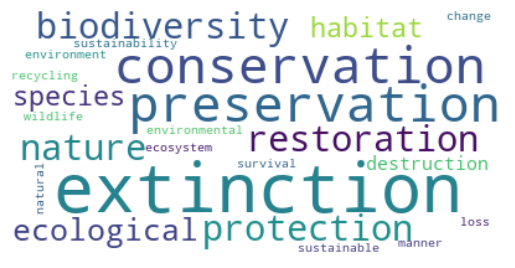

In [99]:
# Create a list of words
from wordcloud import WordCloud
words = ['conservation', 'preservation', 'biodiversity protection',
        'nature restoration', 'ecological', 'species extinction',
        'habitat destruction', 'extinctions', 'sustainability',
        'ecosystem loss', 'wildlife survival', 'sustainable manner',
        'environmental change', 'recycling', 'natural environment']

# Create a string from the list of words
text = ' '.join(words)

# Create and generate a word cloud image
wordcloud = WordCloud(background_color='white').generate(text)

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [94]:
#value_counts worked well when only 10 similar phrases kept per keyword. Less good when many kept

In [30]:
s = df_sim_phrases.stack()
counts = s.value_counts()
tags_df = counts.reset_index()
tags_df.columns = ['word', 'theme score']
tags_df

,word,theme score
0,environment carbon,480
1,climate,459
2,council,457
3,councils,451
4,council management,446
...,...,...
12820,lyme technology,5
12821,borehole cost,4
12822,shorter bite size,4
12823,lyme stays,3


In [33]:
tags_df[(tags_df['theme score']<300) & (tags_df['theme score']>200)]

,word,theme score
151,summary climate,299
152,strategy,299
153,need emissions,299
154,sustainability projects,299
155,further initiatives,298
...,...,...
950,united kingdom,201
951,ambitious reduction,201
952,environment agenda,201
953,city organisation,201


In [673]:
# print(list(counts_df[counts_df['theme score']>300]['word']))

In [676]:
#same process for thematic score where similar words removed
t = df.stack()
tcounts = t.value_counts()
tcounts_df = tcounts.reset_index()
tcounts_df.columns = ['word', 'theme score']
tcounts_df

,word,theme score
0,changing,303
1,specification,251
2,organisation,234
3,midlands,233
4,dwellings,232
...,...,...
12820,change chapter,1
12821,council climate,1
12822,bau emissions,1
12823,public sector procurement,1


In [677]:
print(list(tcounts_df[tcounts_df['theme score']>100]['word']))

['changing', 'specification', 'organisation', 'midlands', 'dwellings', 'reduces', 'environments', 'considerations', 'vegetation', 'contribution', 'expenses', 'task', 'gardening', 'councils', 'ecological', 'strategies', 'undertaken', 'aberdeen', 'adapting', 'assess', 'ecosystem', 'approaches', 'regions', 'surrey', 'participate', 'neighbourhoods', 'birmingham', 'involvement', 'garden', 'act', 'hazards', 'exeter', 'attempt', 'united kingdom', 'activity', 'contribute', 'logistics', 'undertaking', 'proposal', 'planning', 'redesign', 'developing', 'expenditure', 'collaborating', 'contributions', 'cornwall', 'continue', 'contributes', 'cheshire', 'crisis', 'landfill', 'result', 'plans', 'bristol', 'pastures', 'councillors', 'operates', 'sheffield', 'urban towns', 'implement', 'production', 'budgeting', 'increases', 'conclusion', 'regulations', 'outlined', 'develop', 'floods', 'edinburgh', 'collaborations', 'save rainwater', 'london', 'adapted', 'actions', 'acts', 'newcastle', 'maintain', 'con

In [61]:
from nltk.stem import PorterStemmer
from collections import Counter

def has_repeated_word(s):
    words = s.split()
        # Count the occurrences of each word
    word_counts = Counter(words)
    
    # Check if any word occurs more than once
    for count in word_counts.values():
        if count > 1:
            return True
    
    return False

# # create a new column using the custom function
counts_df['has_repeated_word'] = counts_df['word'].apply(has_repeated_word)
counts_df


,word,theme score,has_repeated_word
0,environment council,2270,False
1,plans council,2112,False
2,environmental project,2008,False
3,yorkshire council,1937,False
4,environmental projects,1908,False
...,...,...,...
16363,glyphosate agreement,33,False
16364,powered chainsawspole saws,33,False
16365,new suds applications,30,False
16366,lyme stays,24,False


In [670]:
# print(list(counts_df[counts_df['keyword in # plans']==7]['word']))

In [107]:
temp= counts_df[(counts_df['keyword in # plans']>49) & (counts_df['has_repeated_word'] == False)][['word','keyword in # plans']]
temp
temp.to_csv('../data/processed/keywords_appearing_50_times.csv')

,word,keyword in # plans
1,council,239
2,council overview,213
5,emissions,191
7,climate change,183
9,change climate,165
...,...,...
966,council waste disposal,50
967,carbon emission reductions,50
968,cycling development,50
969,cycling routes,50


In [671]:
# print(list(counts_df[(counts_df['keyword in # plans']>60) & (counts_df['has_repeated_word'] == False)]['word']))

In [674]:
df_sim_phrases.to_csv('../data/final/clean_12k_JNNkeyphrases_100_similar.csv')

In [675]:
df_cos_sim.index = index_names
df_cos_sim.to_csv('../data/final/clean_12k_JNNkeyphrases_100_similar_cos_sim.csv')

In [81]:
df_sim_phrases.sample(n=20)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
12281,analyse data,analyse,detailed data,data,qualitative data,data interpretation,analysis,data sets,comprehensive data,external analyse different,...,accident data,more information investigate,further analysis,farms data,electric vehicle data,plan data,additional data collection,relevant conversion data,available input data,mining techniques
6393,external cladding refurbishment,house refurbishment,new build refurbishment,refurbishment work,refurbishment,refurbishment projects,refurbishment scheme,refurbishment standards,refurbishment programme,regeneration housing,...,external weather conditions,internal budget maintenance,redesign services,woodland regeneration,heating applications,external,improved carbon,heating replace,redesign,previous carbon management
152,biodiversity habitats,habitats biodiversity,biodiversity ecosystems,natural habitats,ecological features biodiversity,habitats,biodiversity,wildlife habitats,communities biodiversity,potential biodiversity investigate,...,wider biodiversity carbon,large biodiversity carbon,wildlife species,better habitat management,biodiversity brighton,biodiversity audit,fauna,priority habitats,new habitat,human history biodiversity
13214,forward panel,panel,panels,forward,panel installation,forward programme,panel type,international panel,forward actions,panel recommendations,...,transport section,photovoltaic,transport steering,control retrofit,other power station,direct transport transition,neutral plan greenwich,external partners section,mobility grid,electricity grids
6276,further reporting requirements,reporting requirements,reporting guidelines,specific reporting,reporting obligations,reporting guidance,reporting procedures,reports detail,statutory reporting,specific reporting measures,...,annual report ref,annual report,reporting year,delivery report,change report,statutory requirements reputation,main report,systems report,public consultation report,second progress report
6920,educational facilities,facilities,education centres,community facilities,schools buildings,various community facilities,schools,buildings schools,local school,official school buildings,...,council building,sports centres,establish programme,operational buildings,council area,council buildings,low toilet facilities,leisure centre,staff workshops,residential buildings
12792,ev model,ev,ev versions,ev transition,ev community,ev implementation strategy,ev provision,ev fleet vehicles,ev infrastructure,ev fleet,...,euro diesel vehicles,electric pool cars,emission,vehicles page,hybrid vehicle,emissions page,cars development,eco action,emissions chapter,electric bike
10072,vulnerable residents,vulnerable citizens,vulnerable houses,support residents,vulnerable households,vulnerable,residents,encourage residents,vulnerability assessment,influence residents,...,short term landlords,neighbourhood plan,housing improvements,local council,housing future,brent residents,eligible homes,housing ev,community council,healthy communities councillor
12551,intend,intention,aims,plans,plan action,undertaking,plan scope,ambition,particular aims,other plans,...,plan key,planning submissions,transition plan,aiming,development goal,plan programmes,planning legislation,part plan,uk plans,relevant action plans
5606,global temperature increase,global temperature rise,global temperature rises,global temperature,worldwide temperature rises,global temperatures,temperature increase,temperature increases,global temperatures figure,variable temperature increase,...,climate implications,climate shocks,wider climate,sea temperatures,solve climate,climatic changes action,reduce climate,average temperatures,citywide climate change,create climate
